In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
from torchvision import transforms

In [2]:
class CNN_EMnist(nn.Module):
    def __init__(self):
        super(CNN_EMnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 8)
        self.z_log_var = nn.Linear(16, 8)

        self.decoder = nn.Sequential(
            nn.Linear(8, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = EMNIST(root='~/data', train=True, split = 'bymerge', download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
testset = EMNIST(root='~/data', train=False, split = 'bymerge', download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561753746/561753746 [04:22<00:00, 2142034.99it/s]


Extracting /home/khoidh/data/EMNIST/raw/gzip.zip to /home/khoidh/data/EMNIST/raw
697932 116323
5453 909


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_EMnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 30

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 358.12it/s]


Epoch: 0 - TrainRecLoss: 47.792324073857266 - ValidRecLoss: 43.17227158583168
Epoch: 0 - TrainDivLoss: 4.503908535670889 - ValidDivLoss: 5.082904701841415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 372.14it/s]


Epoch: 1 - TrainRecLoss: 41.933249925662025 - ValidRecLoss: 40.942558531976246
Epoch: 1 - TrainDivLoss: 5.407112889698224 - ValidDivLoss: 5.643399876467597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 372.45it/s]


Epoch: 2 - TrainRecLoss: 40.39192763551887 - ValidRecLoss: 40.219817326276086
Epoch: 2 - TrainDivLoss: 5.828063444109241 - ValidDivLoss: 5.831747671951948


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 366.02it/s]


Epoch: 3 - TrainRecLoss: 39.64209756408725 - ValidRecLoss: 39.410712037542865
Epoch: 3 - TrainDivLoss: 6.042918343511651 - ValidDivLoss: 6.2023051863062895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 374.40it/s]


Epoch: 4 - TrainRecLoss: 39.1782000884646 - ValidRecLoss: 38.90980030391345
Epoch: 4 - TrainDivLoss: 6.188301477129691 - ValidDivLoss: 6.319434554138855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 359.22it/s]


Epoch: 5 - TrainRecLoss: 38.84128981267949 - ValidRecLoss: 38.862593966611016
Epoch: 5 - TrainDivLoss: 6.300392038512181 - ValidDivLoss: 6.286128715057709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 364.10it/s]


Epoch: 6 - TrainRecLoss: 38.570443068559776 - ValidRecLoss: 38.5368494216365
Epoch: 6 - TrainDivLoss: 6.392002287510883 - ValidDivLoss: 6.366557302254654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 363.94it/s]


Epoch: 7 - TrainRecLoss: 38.365544494567345 - ValidRecLoss: 38.46268727100066
Epoch: 7 - TrainDivLoss: 6.46137183018175 - ValidDivLoss: 6.426673584907624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 367.68it/s]


Epoch: 8 - TrainRecLoss: 38.21354914402363 - ValidRecLoss: 38.30094806431937
Epoch: 8 - TrainDivLoss: 6.510042041720501 - ValidDivLoss: 6.570063939844683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 363.67it/s]


Epoch: 9 - TrainRecLoss: 38.08657536383355 - ValidRecLoss: 38.099990169076115
Epoch: 9 - TrainDivLoss: 6.557806075963759 - ValidDivLoss: 6.516257024309685


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 370.31it/s]


Epoch: 10 - TrainRecLoss: 37.9791843366037 - ValidRecLoss: 38.375109291706146
Epoch: 10 - TrainDivLoss: 6.590944614144568 - ValidDivLoss: 6.568623835497563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 368.36it/s]


Epoch: 11 - TrainRecLoss: 37.88834558441817 - ValidRecLoss: 38.13611713153432
Epoch: 11 - TrainDivLoss: 6.6243976229771375 - ValidDivLoss: 6.605660844557356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 357.36it/s]


Epoch: 12 - TrainRecLoss: 37.81096832734302 - ValidRecLoss: 37.79710559404329
Epoch: 12 - TrainDivLoss: 6.648527819498644 - ValidDivLoss: 6.625628893656043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 357.76it/s]


Epoch: 13 - TrainRecLoss: 37.73287037790488 - ValidRecLoss: 38.017654393765795
Epoch: 13 - TrainDivLoss: 6.6768249052283135 - ValidDivLoss: 6.579062860004186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 377.97it/s]


Epoch: 14 - TrainRecLoss: 37.670162087948896 - ValidRecLoss: 37.59350190199379
Epoch: 14 - TrainDivLoss: 6.69815488047891 - ValidDivLoss: 6.711893379622691


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 372.32it/s]


Epoch: 15 - TrainRecLoss: 37.60604734331582 - ValidRecLoss: 37.602315971953644
Epoch: 15 - TrainDivLoss: 6.716519164794216 - ValidDivLoss: 6.697367224362817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 360.17it/s]


Epoch: 16 - TrainRecLoss: 37.54565098026401 - ValidRecLoss: 37.54410387633001
Epoch: 16 - TrainDivLoss: 6.735959669788584 - ValidDivLoss: 6.717345463823039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 371.83it/s]


Epoch: 17 - TrainRecLoss: 37.48604592064991 - ValidRecLoss: 37.51652200780686
Epoch: 17 - TrainDivLoss: 6.7525235924090286 - ValidDivLoss: 6.822349011176753


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 365.34it/s]


Epoch: 18 - TrainRecLoss: 37.43195068090744 - ValidRecLoss: 37.452129045073086
Epoch: 18 - TrainDivLoss: 6.776630035741776 - ValidDivLoss: 6.748604757688751


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 367.87it/s]


Epoch: 19 - TrainRecLoss: 37.375503426710445 - ValidRecLoss: 37.27546540817412
Epoch: 19 - TrainDivLoss: 6.795994490324937 - ValidDivLoss: 6.889226742965816


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 367.25it/s]


Epoch: 20 - TrainRecLoss: 37.331114633442304 - ValidRecLoss: 37.382915366731986
Epoch: 20 - TrainDivLoss: 6.808943597893966 - ValidDivLoss: 6.70898364426935


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 376.12it/s]


Epoch: 21 - TrainRecLoss: 37.28618409230078 - ValidRecLoss: 37.34703136985451
Epoch: 21 - TrainDivLoss: 6.822163626532499 - ValidDivLoss: 6.842975367807319


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 342.13it/s]


Epoch: 22 - TrainRecLoss: 37.240181996541224 - ValidRecLoss: 37.38100067826912
Epoch: 22 - TrainDivLoss: 6.841827208768899 - ValidDivLoss: 6.782457607676356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 342.79it/s]


Epoch: 23 - TrainRecLoss: 37.2006569793634 - ValidRecLoss: 37.133275249216815
Epoch: 23 - TrainDivLoss: 6.850613675903623 - ValidDivLoss: 6.920687511809195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 332.31it/s]


Epoch: 24 - TrainRecLoss: 37.16414039628606 - ValidRecLoss: 37.26707291471945
Epoch: 24 - TrainDivLoss: 6.862145467611621 - ValidDivLoss: 6.832580427918891


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 338.10it/s]


Epoch: 25 - TrainRecLoss: 37.13702751661952 - ValidRecLoss: 37.13909111400642
Epoch: 25 - TrainDivLoss: 6.875199095035024 - ValidDivLoss: 6.93963970734079


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 334.58it/s]


Epoch: 26 - TrainRecLoss: 37.099948958958834 - ValidRecLoss: 37.087997566617624
Epoch: 26 - TrainDivLoss: 6.883933050969577 - ValidDivLoss: 6.89378567497329


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 344.03it/s]


Epoch: 27 - TrainRecLoss: 37.06715947991879 - ValidRecLoss: 37.214866625593835
Epoch: 27 - TrainDivLoss: 6.8961272294775355 - ValidDivLoss: 6.848543481858257


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 333.80it/s]


Epoch: 28 - TrainRecLoss: 37.036261056423974 - ValidRecLoss: 37.22754630161197
Epoch: 28 - TrainDivLoss: 6.9082003195045765 - ValidDivLoss: 6.886696614579137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 342.96it/s]

Epoch: 29 - TrainRecLoss: 37.01293897322727 - ValidRecLoss: 37.19011888829264
Epoch: 29 - TrainDivLoss: 6.9180655228464225 - ValidDivLoss: 6.84008356341959


In [7]:
def interpolate(autoencoder, x_1, x_2, n=20):
    z_1 = autoencoder.get_latent(x_1)[0]
    z_2 = autoencoder.get_latent(x_2)[0]
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    fig, ax = plt.subplots(figsize=(15, 2))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

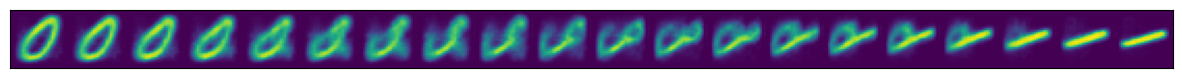

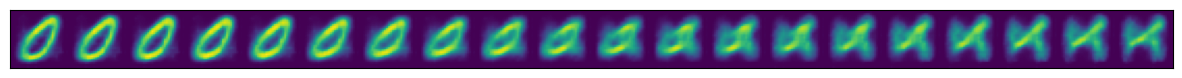

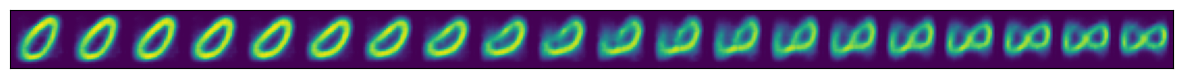

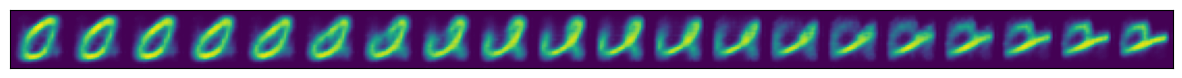

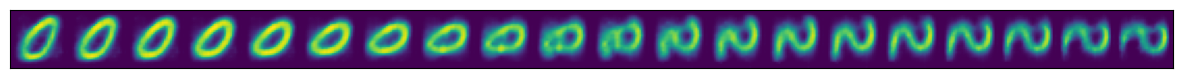

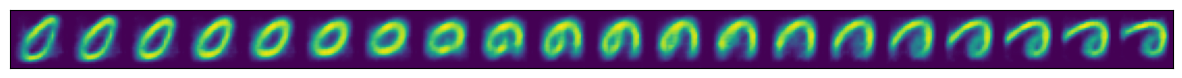

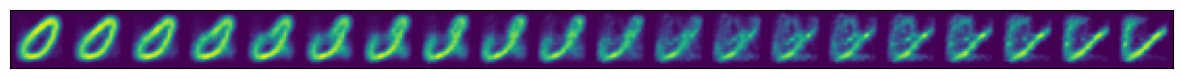

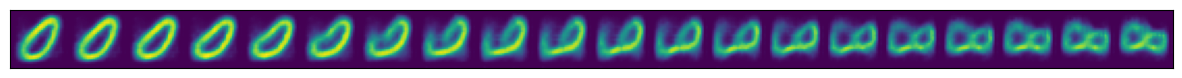

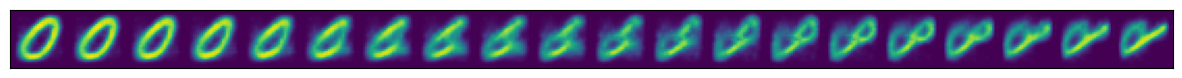

In [8]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_dl))
    x_1 = x[y == 0][1].to(device).unsqueeze(0)
    
    for idx in range(1, 10):
        x_2 = x[y == idx][1].to(device).unsqueeze(0)
        interpolate(model, x_1, x_2, n=20)

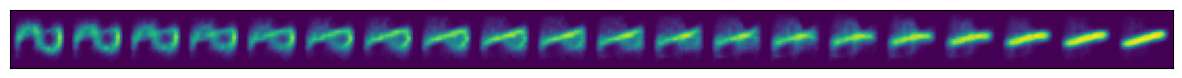

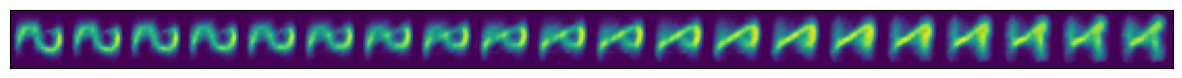

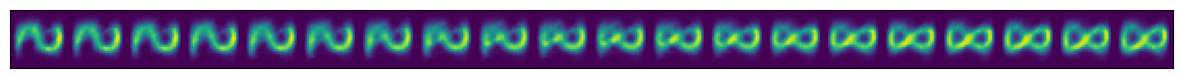

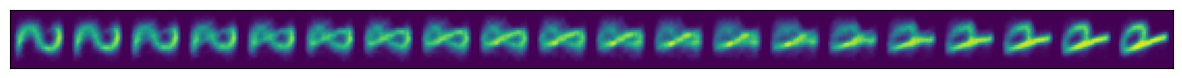

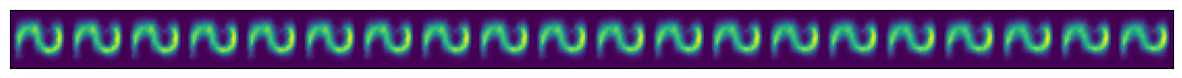

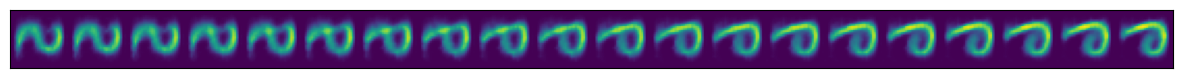

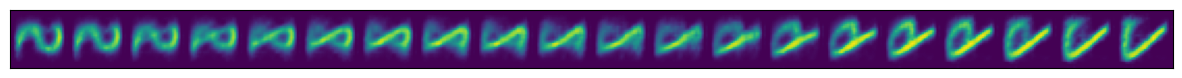

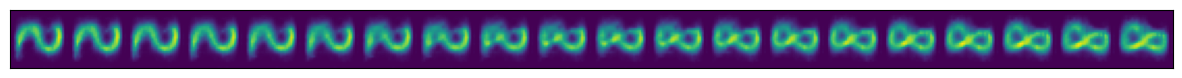

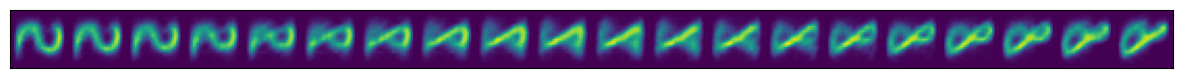

In [9]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_dl))
    x_1 = x[y == 5][1].to(device).unsqueeze(0)
    
    for idx in range(1, 10):
        x_2 = x[y == idx][1].to(device).unsqueeze(0)
        interpolate(model, x_1, x_2, n=20)